# INF8111 - Fouille de données


## TP2 Automne 2019 - Détection de discours d'incitation à la haine

##### Membres de l'équipe:

    - MAINKA Adrien (2046374)
    - BAKKAOUI Mehdi (2038803)
    - METAIS Marianne (2038757)

In [89]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import words_repeated_char
import sys
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 1. Preprocessing

In [90]:
def read_csv(file_path, delimiter = ' '):
    """ We had some issues loading the data using pandas.read_csv, so we built our own loader.
        Read a csv file, returns a pandas.Dataframe
    """
    fp = open(file_path, encoding="utf8")
    line = fp.readline()
    data_dict = dict()
    labels = line[:-1].split(delimiter)
    line = fp.readline()
    for label in labels:
        data_dict[label] = []
    while line:
        for i, j in enumerate(line[:-1].split(delimiter)):
            data_dict[labels[i]].append(j)
        line = fp.readline()
    return pd.DataFrame(data_dict)

In [91]:
data = read_csv("data/hateful_tweets_filtered.csv", delimiter='\t')

In [92]:
data.head()

,tweet_id,label,tweet_content
0,7629505483,abusive,I fuckin hate when niggas stare at me fuck r u...
1,12181574836,abusive,everyone jumps to silly conclusions as soon as...
2,25381445793,abusive,#sincewerebeinghonest I'm Emo. I Need A Fuckin...
3,192730077165916160,abusive,banana bread recipe: 1. get some bread 2. i do...
4,280882735374028800,abusive,godamn this bitch so bad i want 2 drink molly ...


In [93]:
preprocessed = []
for i, tweet in enumerate(data["tweet_content"].values[:]):
    tmp = tweet.lower().replace("\\n",' ').replace('\\xa0', ' ').replace('\\r', ' ').replace("\\'","'").replace("&lt;",'<')\
         .replace("&gt;",'>').replace(" &amp; ", " and ").replace("&amp;", "&")
    # lower the tweet and replacing characters that tweeter has tranlated to their hmtl numeric code to their original value
    tmp = re.sub("(http(s)?://)?(www\.)?([a-zA-Z0-9])+\.[a-z]{1,3}(/\S*)?",'URL', tmp) # 
    tmp = re.sub("#\w+", 'HASHTAG', tmp)
    tmp = re.sub("@\w+", 'USER', tmp)
    tmp = re.sub("\w+@\w+\.[a-z]{2,3}", "EMAIL", tmp)
    tmp = re.sub("[0-9]{1,2}/[0-9]{1,2}/([0-9]{4}|[0-9]{2})|([0-9]{4}|[0-9]{2})/[0-9]{1,2}/[0-9]{1,2}|[0-9]{2}/[0-9]{2}", "DATE", tmp)
    tmp = re.sub("[0-9]{2}(:[0-9]{2}){1,2}( ?(am|pm))?", "TIME", tmp)
    tmp = re.sub("(([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF]))+", ' EMOJI ', tmp)
    tmp = tmp.encode(encoding='ascii', errors='ignore').decode()
    # get rid of the non ascii characters
    tmp = re.sub("\.{2,}", "...", tmp)
    for c in ['!', '-', ',']:
        tmp = re.sub("{}+".format(c), c, tmp)
    tmp = re.sub("\?+", "?", tmp)
    tmp = re.sub("`+", "'", tmp)
    tmp = re.sub("'{2,}", "'", tmp)
    tmp = tmp.translate(str.maketrans(dict.fromkeys('#*+/<=>@[\\]^_`{|}~'))) #removing all the other special characters
    tokens = [t if t not in ["''", "``"] else '"' for t in word_tokenize(tmp) ]
    # tokenizing using nltk.word_tokenize. althought it transforms '"' into '``' or "''" and this is a behaviour do not want
    # so we make sure that the '"' are changed to their original form
    for i, token in enumerate(tokens):
        if re.search(r"([a-z])\1{2,}", token):
            # cleaning the words containing a letter repeated 3 times or more, using the list of the Ensglish words
            tokens[i] = words_repeated_char.clean(token)
    preprocessed.append(tokens)

In [94]:
data["preprocessed"] = preprocessed

In [95]:
data.head()

,tweet_id,label,tweet_content,preprocessed
0,7629505483,abusive,I fuckin hate when niggas stare at me fuck r u...,"[i, fuckin, hate, when, niggas, stare, at, me,..."
1,12181574836,abusive,everyone jumps to silly conclusions as soon as...,"[everyone, jumps, to, silly, conclusions, as, ..."
2,25381445793,abusive,#sincewerebeinghonest I'm Emo. I Need A Fuckin...,"[HASHTAG, i, 'm, emo, ., i, need, a, fucking, ..."
3,192730077165916160,abusive,banana bread recipe: 1. get some bread 2. i do...,"[banana, bread, recipe, :, 1., get, some, brea..."
4,280882735374028800,abusive,godamn this bitch so bad i want 2 drink molly ...,"[godamn, this, bitch, so, bad, i, want, 2, dri..."


## 2. Jeu de données

In [96]:
from sklearn.model_selection import train_test_split

X = preprocessed
y = []


for i in range(len(data)):
    
    if data["label"][i] == "hateful":
        y.append(0)
    elif data["label"][i] == "abusive":
        y.append(1)
    elif data["label"][i] == "spam":
        y.append(2)
    elif data["label"][i] == "normal":
        y.append(3)

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))

Length of training set :  42056
Length of validation set :  9233
Length of test set :  9052


## 3. Stemming

In [97]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tweet):
        """
        tweet: a list of string
        """
        # Have to return the stemmed tweet
        return list(map(self.stemmer.stem , tweet))

In [98]:
s=Stemmer()
X = list(map(s.stem, X))

## 4. Classification

In [99]:
import numpy as np
from sklearn.metrics import accuracy_score


def train_evaluate(classifier, training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    classifier: model used (LogisticRegression...)
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))

    return classifier, trainAcc, validationAcc

In [100]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def function(token):
    return token

def model_comparison(classifier, nom_classifier):
    """
    classifier: model used (LogisticRegression...)
    nom_classifier: model name
    
    :return: Comparison of the classifier with CountBoW, TF-IDF, unigram and bigram.
    """
    
    trainAcc = []
    validationAcc = []

    # 1.classifier + CountBoW + unigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 2.classifier + CountBoW + unigram + bigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, cv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 3.classifier + TF-IDF + unigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])

    # 4.classifier + TF-IDF + unigram + bigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,test_X, test_Y, valid_X, valid_Y, tv)
    trainAcc.append(model[1])
    validationAcc.append(model[2])
    
    # Graphe de comparaison des différents modèles
    
    r=np.arange(len(trainAcc))
    
    TypeAcc = ["Training", "Validation"]
    models_names = ['CountBoW \nunigram', 'CountBoW \nunigram \nbigram', 
     'TF-IDF \nunigram', 'TF-IDF \nunigram \nbigram']
    bar_width = 0.4

    plt.bar(r, trainAcc,bar_width)
    plt.bar(r+bar_width, validationAcc,bar_width)
    plt.xticks(r+bar_width/2, models_names, rotation=0)

    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')

    plt.title(nom_classifier)

    plt.legend(TypeAcc)

    for i in range(len(trainAcc)):
        plt.text(x = r[i]-bar_width/2 , y = trainAcc[i]+0.01, s = '%.4f' % trainAcc[i])
        plt.text(x = r[i]+bar_width/2 , y = validationAcc[i]+0.01, s = '%.4f' % validationAcc[i])

    plt.ylim(.5, 1.2)
    plt.show()

### 5.1 Modèles linéaires

#### 5.1.1 Régression logistique

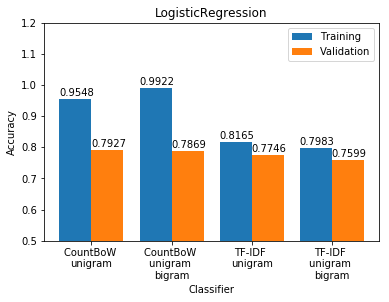

In [101]:
from sklearn.linear_model import LogisticRegression

model_comparison(LogisticRegression(),'LogisticRegression')

#### 5.1.2 Stochastic Gradient Descent

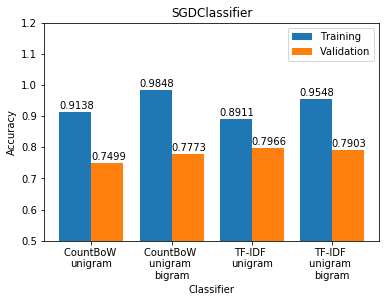

In [102]:
from sklearn.linear_model import SGDClassifier

model_comparison(SGDClassifier(),'SGDClassifier')

#### 5.1.3 Perceptron

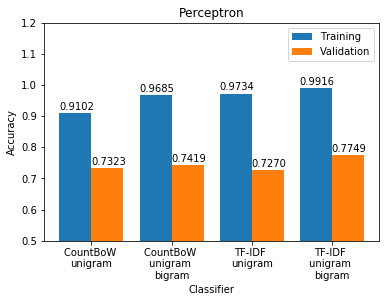

In [103]:
from sklearn.linear_model import Perceptron

model_comparison(Perceptron(),'Perceptron')

#### 5.1.4 PassiveAggressiveClassifier

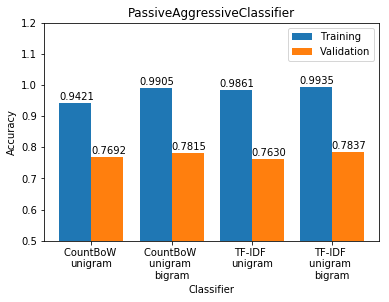

In [104]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_comparison(PassiveAggressiveClassifier(),'PassiveAggressiveClassifier')

### 5.2 Support Vector Machines 

#### 5.2.1  Linear Support Vector Classification

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


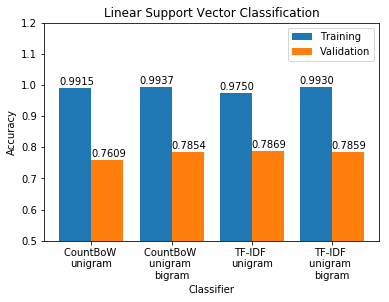

In [105]:
from sklearn.svm import LinearSVC 

model_comparison(LinearSVC(),'Linear Support Vector Classification')

### 5.3 Decision Trees

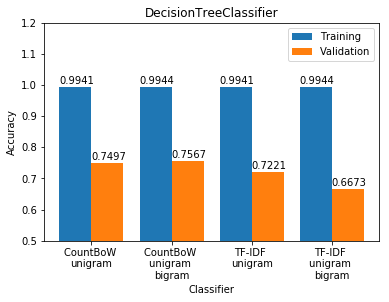

In [106]:
from sklearn.tree import DecisionTreeClassifier

model_comparison(DecisionTreeClassifier(),'DecisionTreeClassifier')